Öznitelik sayısı: 5000
Vektörlenmiş veri şekli: (50000, 5000)
Eğitim verisi şekli (NumPy): (40000, 5000)
Test verisi şekli (NumPy): (10000, 5000)
PyTorch modeli 'cpu' üzerinde çalışacak.
Epoch [1/10], Eğitim Kaybı: 0.4358, Eğitim Doğruluğu: 0.8208, Doğrulama Kaybı: 0.2926, Doğrulama Doğruluğu: 0.8835
Epoch [2/10], Eğitim Kaybı: 0.2689, Eğitim Doğruluğu: 0.8963, Doğrulama Kaybı: 0.2789, Doğrulama Doğruluğu: 0.8838
Epoch [3/10], Eğitim Kaybı: 0.2211, Eğitim Doğruluğu: 0.9161, Doğrulama Kaybı: 0.2865, Doğrulama Doğruluğu: 0.8818
Epoch [4/10], Eğitim Kaybı: 0.1888, Eğitim Doğruluğu: 0.9299, Doğrulama Kaybı: 0.3002, Doğrulama Doğruluğu: 0.8830
Epoch [5/10], Eğitim Kaybı: 0.1537, Eğitim Doğruluğu: 0.9462, Doğrulama Kaybı: 0.3119, Doğrulama Doğruluğu: 0.8803
Epoch [6/10], Eğitim Kaybı: 0.1236, Eğitim Doğruluğu: 0.9598, Doğrulama Kaybı: 0.3381, Doğrulama Doğruluğu: 0.8800
Epoch [7/10], Eğitim Kaybı: 0.0987, Eğitim Doğruluğu: 0.9667, Doğrulama Kaybı: 0.3735, Doğrulama Doğruluğu: 0.8794
Epoch [8

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


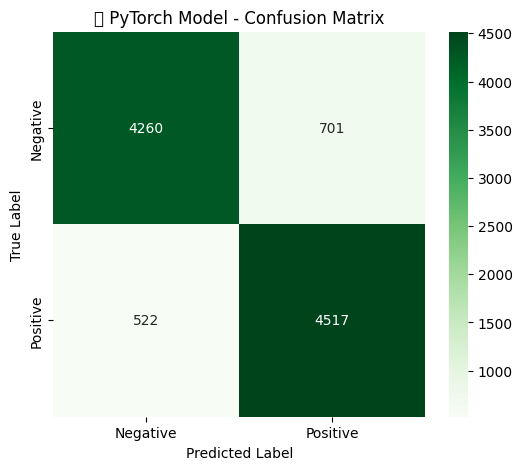

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


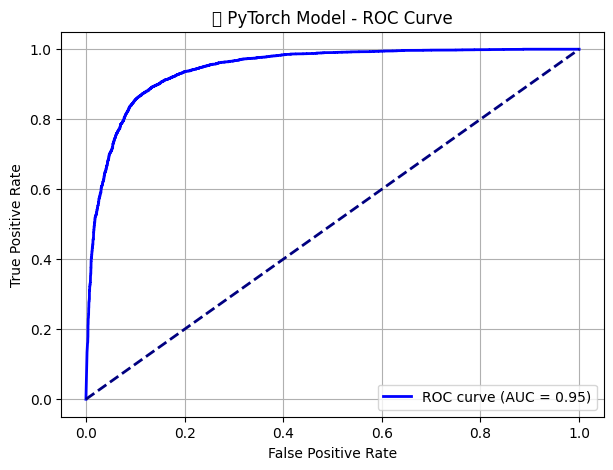

✅ PyTorch Model - ROC AUC Score: 0.9454


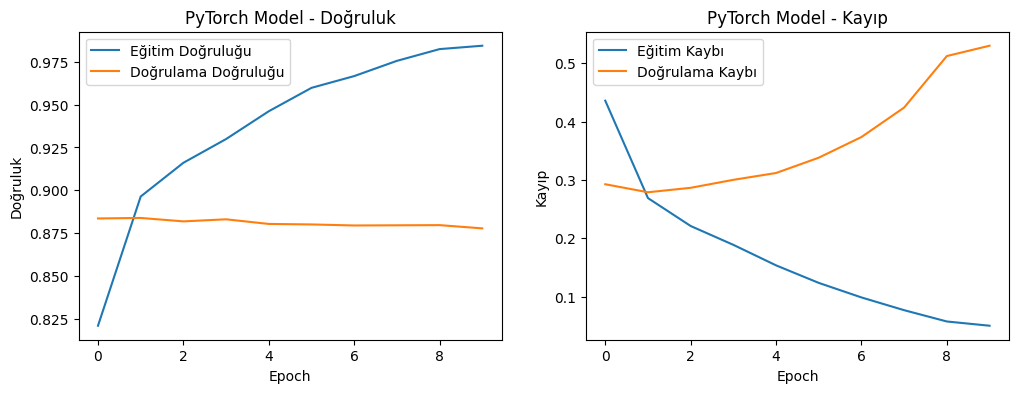

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk # NLTK verilerini indirmek için eklendi

# NLTK stopwords verisini indirme
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

# Veri setini yükleme
df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv") 

# Önişleme fonksiyonu
stemmer = PorterStemmer()
stop_words_list = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words_list]
    return " ".join(tokens)

df["cleaned_review"] = df["review"].apply(preprocess)

# Metinleri vektörleştiriyoruz
vectorizer = CountVectorizer(stop_words='english', max_features=5000) # Keras ile aynı max_features
x_vec = vectorizer.fit_transform(df["cleaned_review"])
y = df["sentiment"].map({'positive': 1, 'negative': 0}).values

print("Öznitelik sayısı:", len(vectorizer.get_feature_names_out()))
print("Vektörlenmiş veri şekli:", x_vec.shape)

# dataset bölme
# PyTorch için de yoğun (dense) array'e çeviriyoruz ve sonra tensor'e dönüştüreceğiz
x_train_np, x_test_np, y_train_np, y_test_np = train_test_split(x_vec.toarray(), y, test_size=0.2, random_state=42)

print("Eğitim verisi şekli (NumPy):", x_train_np.shape)
print("Test verisi şekli (NumPy):", x_test_np.shape)

# PyTorch kütüphanelerini import etme
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Verileri PyTorch Tensor'larına dönüştürme
# Modelin beklentisine göre float tipinde olmalı
x_train_torch = torch.tensor(x_train_np, dtype=torch.float32)
y_train_torch = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(1) # Kayıp fonksiyonu için (batch_size, 1) şeklinde olmalı
x_test_torch = torch.tensor(x_test_np, dtype=torch.float32)
y_test_torch = torch.tensor(y_test_np, dtype=torch.float32).unsqueeze(1)

# TensorDataset ve DataLoader oluşturma
train_dataset = TensorDataset(x_train_torch, y_train_torch)
test_dataset = TensorDataset(x_test_torch, y_test_torch)

batch_size_pytorch = 512 # Keras ile aynı batch size
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size_pytorch, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size_pytorch, shuffle=False)


# PyTorch Model Tanımlama
class SentimentClassifierNN(nn.Module):
    def __init__(self, input_dim):
        super(SentimentClassifierNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128) # Keras'taki ilk Dense katmanına benzer
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5) # Keras'taki Dropout katmanına benzer
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 1)     # Keras'taki çıkış katmanına benzer
        self.sigmoid = nn.Sigmoid()     # Keras'taki sigmoid aktivasyonuna benzer

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

input_dim = x_train_torch.shape[1]
model_pytorch = SentimentClassifierNN(input_dim)

# Cihazı belirleme (GPU varsa GPU, yoksa CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pytorch.to(device)
print(f"PyTorch modeli '{device}' üzerinde çalışacak.")

# Kayıp Fonksiyonu ve Optimizatör
criterion = nn.BCELoss() # Binary Cross Entropy Loss, Keras'taki binary_crossentropy'ye denk
optimizer = optim.Adam(model_pytorch.parameters(), lr=0.001) # Keras'taki Adam optimizer'a denk

# Eğitim Döngüsü
num_epochs = 10 # Keras ile aynı epoch sayısı
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model_pytorch.train() # Modeli eğitim moduna al (Dropout gibi katmanlar aktifleşir)
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (features, labels) in enumerate(train_loader):
        features = features.to(device)
        labels = labels.to(device)

        # İleri yayılım
        outputs = model_pytorch(features)
        loss = criterion(outputs, labels)

        # Geri yayılım ve optimizasyon
        optimizer.zero_grad() # Gradyanları sıfırla
        loss.backward()       # Gradyanları hesapla
        optimizer.step()      # Parametreleri güncelle

        running_loss += loss.item() * features.size(0)
        predicted = (outputs > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct_train / total_train
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Doğrulama (Validation)
    model_pytorch.eval() # Modeli değerlendirme moduna al (Dropout gibi katmanlar devre dışı kalır)
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    all_val_labels = []
    all_val_probas = []

    with torch.no_grad(): # Gradyan hesaplamalarını durdur
        for features, labels in test_loader:
            features = features.to(device)
            labels = labels.to(device)
            outputs = model_pytorch(features)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * features.size(0)
            predicted = (outputs > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            all_val_labels.extend(labels.cpu().numpy())
            all_val_probas.extend(outputs.cpu().numpy())

    val_epoch_loss = val_running_loss / len(test_loader.dataset)
    val_epoch_acc = correct_val / total_val
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Eğitim Kaybı: {epoch_loss:.4f}, Eğitim Doğruluğu: {epoch_acc:.4f}, "
          f"Doğrulama Kaybı: {val_epoch_loss:.4f}, Doğrulama Doğruluğu: {val_epoch_acc:.4f}")


# Model Performansını Değerlendirme
model_pytorch.eval()
y_pred_pytorch_list = []
y_test_pytorch_list = []
y_proba_pytorch_list = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        outputs = model_pytorch(features)
        predicted_classes = (outputs > 0.5).float()
        y_pred_pytorch_list.extend(predicted_classes.cpu().numpy().flatten())
        y_test_pytorch_list.extend(labels.cpu().numpy().flatten())
        y_proba_pytorch_list.extend(outputs.cpu().numpy().flatten())

y_pred_pytorch = np.array(y_pred_pytorch_list)
y_true_pytorch = np.array(y_test_pytorch_list)
y_proba_pytorch = np.array(y_proba_pytorch_list)

accuracy_pytorch = accuracy_score(y_true_pytorch, y_pred_pytorch)
print(f"\nPyTorch Model - Test Doğruluğu: {accuracy_pytorch:.4f}")

# Classification Report
print("\nPyTorch Model - Classification Report:")
print(classification_report(y_true_pytorch, y_pred_pytorch, target_names=["negative", "positive"]))

# Confusion Matrix
conf_matrix_pytorch = confusion_matrix(y_true_pytorch, y_pred_pytorch)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_pytorch, annot=True, fmt="d", cmap="Greens", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("🔍 PyTorch Model - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve ve AUC
fpr_pytorch, tpr_pytorch, thresholds_pytorch = roc_curve(y_true_pytorch, y_proba_pytorch)
roc_auc_pytorch = roc_auc_score(y_true_pytorch, y_proba_pytorch)

plt.figure(figsize=(7, 5))
plt.plot(fpr_pytorch, tpr_pytorch, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_pytorch:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('🧠 PyTorch Model - ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"✅ PyTorch Model - ROC AUC Score: {roc_auc_pytorch:.4f}")

# Eğitim geçmişini görselleştirme (isteğe bağlı)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Eğitim Doğruluğu')
plt.plot(val_accuracies, label='Doğrulama Doğruluğu')
plt.title('PyTorch Model - Doğruluk')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Eğitim Kaybı')
plt.plot(val_losses, label='Doğrulama Kaybı')
plt.title('PyTorch Model - Kayıp')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()